# pre processing

Importing packages

In [1]:
import pygeostat as gs
import numpy as np
from hier_bound_sim_helpers import *
import matplotlib.pyplot as plt
from scipy.spatial import distance

Importing data

In [2]:
cp = gs.DataFile(flname='data/copper.txt', x='X', y='Y',z='Z',dh='DH')

Dropping columns

In [3]:
cols = ['SD_{}'.format(i) for i in range(2,7)]
cp.drop(columns=cols)

Transforming to int

In [4]:
cp['Cat'] = [int(val) for val in cp['Cat']]
cp['DH'] = [int(val) for val in cp['DH']]

Translating to origin and converting to meters

In [5]:
cp.data.X = (cp.data.X - min(cp.data.X) if min(cp.data.X) > 0 else cp.data.X + min(cp.data.X))*1000
cp.data.Y = (cp.data.Y - min(cp.data.Y) if min(cp.data.Y) > 0 else cp.data.Y + min(cp.data.Y))*1000
cp.data.Z = (cp.data.Z - min(cp.data.Z) if min(cp.data.Z) > 0 else cp.data.Z + min(cp.data.Z))*1000

In [6]:
cp['Cat'] = cp['Cat'] - 1

Checking domains

In [7]:
unique = cp['Cat'].unique()
unique.sort()
unique = unique[~np.isnan(unique)]
print(unique)

[1 2 3 4 5]


Saving new data

In [8]:
gs.write_gslib(cp, 'data/Coper_mod.dat')

In [9]:
cp = gs.DataFile(flname='data/Coper_mod.dat', x='X', y='Y',z='Z',dh='DH')

In [10]:
cp.head()

,DH,X,Y,Z,Cat
0,52.0,783.0200,517.578,0.000000,4.0
1,64.0,1161.0107,569.824,3.000021,1.0
2,52.0,786.0107,517.578,15.000105,4.0
3,64.0,1158.0200,567.871,19.000053,1.0
4,52.0,787.9944,518.554,30.000210,4.0


Saving to vtk

In [11]:
gs.write_vtk(cp, 'Outputs/copper_points')

In [12]:
grid = cp.infergriddef(blksize=[50,50,30], databuffer=0)

In [13]:
grid

Pygeostat GridDef:
34 25.0 50.0 
26 25.0 50.0 
50 15.0 30.0

# creating the proto model

In [14]:
rbfdfmod = gs.Program('RBFDFMOD/rbfdfmod.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach\Notebooks\tmpi8nvvcvb\rbfdfmod.par has been copied to the clipboard


In [15]:
parstr = """                        rbfdfmod
                        ********

START OF PARAMETERS:
{flname}                -file with input dataset
2  3  4  5               - column for x, y, z, indicator data
-999                     - trimming value
5 1 2 3 4 5                -ncats, category indicator
keyout.dat               -file with the keyout model
1  1                     - column for keyout variable, value to keep
{grid}
2 0 0 0 0 0               -RBFinterp type (1:direct, 2:POU)-NOTE 1, trained C parameter(s)-NOTE 3
1  0.0001                 - RBF kernel (NOTE 2), Nugget Effect
1  350  1000              - Support (0:manual,1:auto) - NOTE 2, support distance, extrapolation distance
0                        -Use different anisotropy for each category? (1=Yes,0=No) - NOTE 4
0  0  0                  - Anisotropic orientations (str,dip,plunge) / Cat1
1  1                     - Anisotropic ratios (minor/major, vertical/major, <= 1.0)
1    8                   -Ouput: (1) indicators or (2) signed distacnce function, numthreads for parallel SDF
Outputs/proto_copper.out                -file for interpolated output
*** BPT parameter section: ***  
95  0.06  1              -Partition paramters: dpc, d overlap, weight func (1 or 2, see paper)
 0.5 0.5 0.5             - final partition overlap in x, y, z directions
0                        -read BPT parameters from file(1=Yes,0=No) - NOTE 6
BPT_bounds.out           -file with partition boundaries
BPT_aniso_cat2_ref4.out  -file(s) with anisotropy for each category
"""

parstr = parstr.format(flname=cp.flname, grid=grid)

rbfdfmod.run(parstr=parstr, liveoutput=True)

Calling:  ['RBFDFMOD/rbfdfmod.exe', 'temp']
 rbfdfmod, version :  2.00
Datafile: data/Coper_mod.dat                      
 xcol,ycol and zcol and datcol:   2  3  4  5
 trimming limit:         -999.00
 categories to model:          1         2         3         4         5
 nx, xmn, xsiz =   34        25.0000          50.0000
 ny, ymn, ysiz =   26        25.0000          50.0000
 nz, zmn, zsiz =   50        15.0000          30.0000
 Interpolation Type:  Partition of Unity  
 Kernel Type: Gaussian            
Automatically determining support from data spacing
Will only consider grid locations falling within this
  distance from data:    1000.0000    
 Using one set of aniostropic properties for all categories 
 Using the following for all categories: 
Using these angles:          0.0000000       0.0000000       0.0000000    
 minor/major, vert/major:    1.0000000       1.0000000    
Exporting an indicator grid
File to write outputs to: Outputs/proto_copper.out
Final Partition Overlap in

In [16]:
proto = gs.DataFile('Outputs/proto_copper.out', griddef=grid)

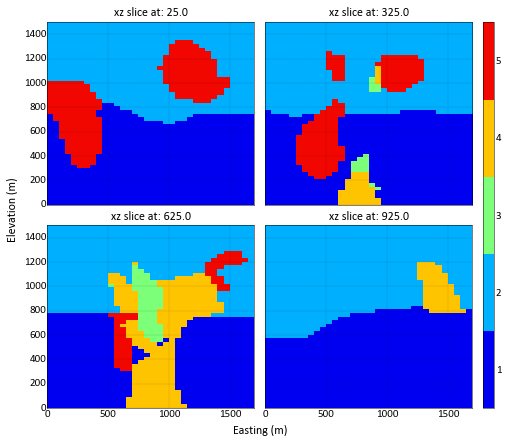

In [17]:
_ = gs.grid_slice_plot(proto, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/proto_slicces.png', )

# defining groups

In [18]:
c_delim, maps = grouping(df=cp, rock='Cat', grid=grid, prop=proto['Cat'])

Marching the cubes...
3D
Counting contacts...
Contacts count:  {(1.0, 2.0): 1073, (2.0, 5.0): 1056, (2.0, 4.0): 766, (1.0, 4.0): 732, (1.0, 5.0): 720, (3.0, 4.0): 286, (4.0, 5.0): 188, (2.0, 3.0): 187, (1.0, 3.0): 162, (1.0, 3.0, 4.0): 120, (2.0, 3.0, 4.0): 103, (2.0, 4.0, 5.0): 101, (1.0, 2.0, 4.0): 62, (3.0, 5.0): 59, (1.0, 4.0, 5.0): 50, (3.0, 4.0, 5.0): 50, (1.0, 2.0, 5.0): 37, (2.0, 3.0, 5.0): 33, (1.0, 2.0, 3.0): 15, (2.0, 3.0, 4.0, 5.0): 12, (1.0, 3.0, 5.0): 7, (1.0, 2.0, 4.0, 5.0): 6, (1.0, 3.0, 4.0, 5.0): 4, (1.0, 2.0, 3.0, 4.0): 4, (1.0, 2.0, 3.0, 4.0, 5.0): 1}
Done!


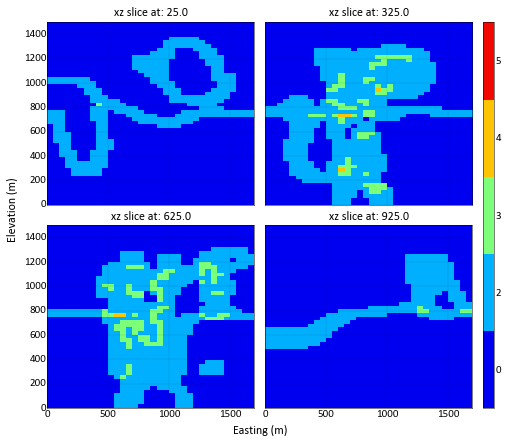

In [19]:
_ = gs.grid_slice_plot(c_delim, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/proto_cdlim.png', )

In [20]:
maps

{'g1': {1.0: 1, 2.0: 1, 4.0: 0, 3.0: 0, 5.0: 0},
 'g2': {1.0: 1, 2.0: 0},
 'g3': {3.0: 1, 4.0: 1, 5.0: 0},
 'g4': {3.0: 1, 4.0: 0}}

In [21]:
proto['cdlim'] = c_delim

In [22]:
gs.write_vtk(proto, 'Outputs/proto', griddef=grid)

In [23]:
groups = df_groups(maps=maps, df=cp, rock='Cat')

In [24]:
groups['g1'].head()

,DH,X,Y,Z,Cat
0,52.0,783.0200,517.578,0.000000,0
1,64.0,1161.0107,569.824,3.000021,1
2,52.0,786.0107,517.578,15.000105,0
3,64.0,1158.0200,567.871,19.000053,1
4,52.0,787.9944,518.554,30.000210,0


In [25]:
def min_dist(point, points):
    dist_matrix = distance.cdist([point], points, "euclidean")
    return np.amin(dist_matrix)

In [26]:
dfg = {}
for g in groups:
    datafileg = gs.DataFile(data=groups[g], x='X', y='Y', z='Z')
    
    unique_rts = np.unique(datafileg['Cat'])
    prop_values = datafileg['Cat'].values
    
    x, y, z = datafileg['X'], datafileg['Y'], datafileg['Z']
    coords_matrix = np.vstack((x,y,z)).T

    for rt in unique_rts:
        #print('calculating signed distances for rock type {}'.format(int(rt)))
        filter_0 = prop_values != rt
        filter_1 = prop_values == rt
        points_0 = coords_matrix[filter_0]
        points_1 = coords_matrix[filter_1]

        sd_prop = []
        for idx, pt in enumerate(prop_values):
            if np.isnan(pt):
                sd_prop.append(float('nan'))

            else:
                point = coords_matrix[idx]
                if pt == rt:
                    sd_prop.append(-min_dist(point, points_0))
                else:
                    sd_prop.append(min_dist(point, points_1))
            
        datafileg['SD_{}'.format(rt)] = sd_prop
                
    datafileg.write_file(flname='data/cp_data_{}'.format(g), fltype='gslib')
    datafileg = gs.DataFile(flname='data/cp_data_{}'.format(g), x='X', y='Y', z='Z')
    dfg[g] = datafileg
    gs.write_vtk(dfg[g], 'Outputs/cp_group_{}'.format(g))

In [27]:
dfg['g1'].head()

,DH,X,Y,Z,Cat,SD_0,SD_1
0,52.0,783.0200,517.578,0.000000,0.0,-286.072158,286.072158
1,64.0,1161.0107,569.824,3.000021,1.0,129.677166,-129.677166
2,52.0,786.0107,517.578,15.000105,0.0,-274.702710,274.702710
3,64.0,1158.0200,567.871,19.000053,1.0,123.592392,-123.592392
4,52.0,787.9944,518.554,30.000210,0.0,-264.800187,264.800187


# variography

In [28]:
var_calc = gs.Program('VARCALC/varcalc.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach\Notebooks\tmp1i6e_n01\varcalc.par has been copied to the clipboard


In [29]:
var_model = gs.Program('VARMODEL/varmodel.exe', getpar=True)

D:\Google Drive\Academia\papers\bound simulation hierarchical approach\Notebooks\tmpf0p6m3bb\varmodel.par has been copied to the clipboard


In [30]:
"""               
NOTES ON VARIOGRAM CALCULATION:
1) By default, varcalc runs checks for common errors in parameter choices. This can be
   disabled if desired. 
2) Varcalc can standardize using a provided sill (such as a declustered variance).
   For example, if variable 1 has a declustered variance of 8.6, the traditional
   semivariogram could be standardized by setting the variogram type to:
      1  1  1  8.6
   Alternatively, varcalc can attempt to infer a sill for standardizing by setting
   the variogram type to:
      1  1  1  ?
   The calculated sills will be written to the console. 
3) Variogram types are the same as in GSLIB:
      1 = traditional semivariogram
      2 = traditional cross semivariogram
      3 = covariance   (-3 calculates variance (provided sill) -covariance)
      4 = correlogram  (-4 calculates 1-correlation)
      5 = general relative semivariogram
      6 = pairwise relative semivariogram
      7 = semivariogram of logarithms
      8 = semimadogram
      9 = indicator semivariogram - continuous  - requires a cutoff
      10= indicator semivariogram - categorical - requires a category
4) For indicator variograms, the variogram cutoff/categories are specified immediately after the variogram type
    1   1   9   1.0   ?               -tail variable, head variable, variogram type (and cutoff/category), sill
5) If desired, the program can write out the variogram points in the gamv2004 style
   for compatibility with older versions. Tilt was not supported in pre-varcalc experimental variogram
   programs so use carefully. 
"""

'               \nNOTES ON VARIOGRAM CALCULATION:\n1) By default, varcalc runs checks for common errors in parameter choices. This can be\n   disabled if desired. \n2) Varcalc can standardize using a provided sill (such as a declustered variance).\n   For example, if variable 1 has a declustered variance of 8.6, the traditional\n   semivariogram could be standardized by setting the variogram type to:\n      1  1  1  8.6\n   Alternatively, varcalc can attempt to infer a sill for standardizing by setting\n   the variogram type to:\n      1  1  1  ?\n   The calculated sills will be written to the console. \n3) Variogram types are the same as in GSLIB:\n      1 = traditional semivariogram\n      2 = traditional cross semivariogram\n      3 = covariance   (-3 calculates variance (provided sill) -covariance)\n      4 = correlogram  (-4 calculates 1-correlation)\n      5 = general relative semivariogram\n      6 = pairwise relative semivariogram\n      7 = semivariogram of logarithms\n      8

In [31]:
n_lags = 30
n_lagsv = 20

lag = 15
lagv = 30

lag_tol = lag/2
lag_tolv = lagv/2

In [32]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{flname}                 -file with data
2   3   4                         -   columns for X, Y, Z coordinates
1   {col_num}                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
90 91 1000 0.0 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlags}  {lag}  {lagtol}                 -        number of lags,lag distance,lag tolerance
{outfl}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1 1 10 1  {var}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

g = 1
prop = np.sum(dfg['g1']['Cat'])/len(dfg['g1']['Cat'])
var = prop - prop ** 2
parstr_e = parstr.format(
        flname=dfg['g{}'.format(g)].flname,
        col_num=dfg['g{}'.format(g)].gscol('Cat'),
        nlags=n_lags,
        nlagsv=n_lagsv,
        lag=lag,
        lagv=lagv,
        lagtol=lag_tol,
        lagtolv=lag_tolv,
        var = var,
        outfl='Outputs/cp_out_fl_{}.out'.format(g))

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='Outputs/varcalc_g_{}_.par'.format(g))

Calling:  ['VARCALC/varcalc.exe', 'Outputs/varcalc_g_1_.par']

varcalc version:  1.400

  data file: data/cp_data_g1
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz   90.0000000000000        91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          30   15.0000000000000     
   7.50000000000000     
  output file: Outputs/cp_out_fl_1.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            1
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   1.00000000000000     
  standardizing with sill =  0.199525986156023   

In [33]:
varmodelpar = parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_out}                 -file for modeled variogram points output
1                            -number of directions to model points along
0.0   90.0  4000   0.5      -  azm, dip, npoints, point separation
1    0:0.5                   -nst, nugget effect
1 ?  0    0   0       -it,cc,azm,dip,tilt (ang1,ang2,ang3)
?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
2   1   2                    -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{model}              -  file to save fit variogram model
"""

g = 1
parstr = varmodelpar.format(model_out='Outputs/cpmodel_file_out_{}.out'.format(g), 
                                exp='Outputs/cp_out_fl_{}.out'.format(g), 
                                model='Outputs/cpvar_model_{}.out'.format(g))
    
var_model.run(parstr=parstr, liveoutput=True)

Calling:  ['VARMODEL/varmodel.exe', 'temp']

varmodel version: 1.1.1

  output points file: Outputs/cpmodel_file_out_1.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        4000  0.500000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.500000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Outputs/cp_out_fl_1.out
  using variograms            1           2
  # pairs wt, inv dist wt, min pairs:            1           0          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: Outputs/cpvar_model_1.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   4.191116688811392E-002
 Final objective value =   1.849272681760337E-002
  Modeling poin

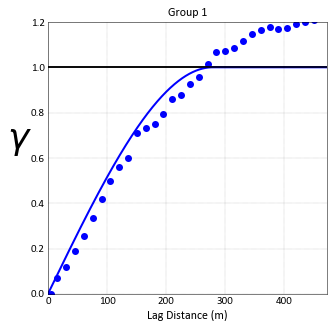

In [34]:
g = 1
varfl = gs.DataFile('Outputs/cp_out_fl_{}.out'.format(g))
modelfl=gs.DataFile('Outputs/cpmodel_file_out_{}.out'.format(g))
_ = gs.variogram_plot(varfl, index=1, grid=True, ms=7, figsize=(5,5), color='blue', title="Group {}".format(g))
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', label="omni horizontal", output_file='images/cp_var_{}.png'.format(g))
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red')
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='images/cp_var_{}.png'.format(g), lw=2, color='red', label="vertical")
#plt.legend(loc=4)

In [35]:
n_lags = 40
n_lagsv = 30

lag = 40
lagv = 15

lag_tol = lag/2
lag_tolv = lagv/2

In [36]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{flname}                 -file with data
2   3   4                         -   columns for X, Y, Z coordinates
1   {col_num}   {col_num}                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
2                                 -number of directions
90 91 1000 0.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlags}  {lag}  {lagtol}                 -        number of lags,lag distance,lag tolerance
0 22.5 1000 90 22.5 1000 0.0     -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlagsv}  {lagv}  {lagtolv}                 -        number of lags,lag distance,lag tolerance
{outfl}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1 10   1 {var}                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

g = 2
prop = np.sum(dfg['g2']['Cat'])/len(dfg['g2']['Cat'])
var = prop - prop ** 2
parstr_e = parstr.format(
        flname=dfg['g{}'.format(g)].flname,
        col_num=dfg['g{}'.format(g)].gscol('Cat'),
        nlags=n_lags,
        nlagsv=n_lagsv,
        lag=lag,
        lagv=lagv,
        lagtol=lag_tol,
        lagtolv=lag_tolv,
        var=var,
        outfl='Outputs/cp_out_fl_{}.out'.format(g))

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='Outputs/varcalc_g_{}_.par'.format(g))

Calling:  ['VARCALC/varcalc.exe', 'Outputs/varcalc_g_2_.par']

varcalc version:  1.400

  data file: data/cp_data_g2
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz   90.0000000000000        91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          40   40.0000000000000     
   20.0000000000000     
 azm,azmtol,bandhorz  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 dip,diptol,bandvert   90.0000000000000        22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          30   15.0000000000000     
   7.50000000000000     
  output file: Outputs/cp_out_fl_2.

In [37]:
varmodelpar = parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_out}                 -file for modeled variogram points output
2                            -number of directions to model points along
90   0.0  4000   0.5      -  azm, dip, npoints, point separation
0.0   90.0  3000   0.5      -  azm, dip, npoints, point separation
1    0:0.5                   -nst, nugget effect
1 ?  0    0   0       -it,cc,azm,dip,tilt (ang1,ang2,ang3)
?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
2   1   2                    -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{model}              -  file to save fit variogram model
"""

g = 2
parstr = varmodelpar.format(model_out='Outputs/cpmodel_file_out_{}.out'.format(g), 
                                exp='Outputs/cp_out_fl_{}.out'.format(g), 
                                model='Outputs/cpvar_model_{}.out'.format(g))
    
var_model.run(parstr=parstr, liveoutput=True)

Calling:  ['VARMODEL/varmodel.exe', 'temp']

varmodel version: 1.1.1

  output points file: Outputs/cpmodel_file_out_2.out
  number of directions to model points along:            2
  azm, dip, npoints, pointsep:    90.0000000000000       0.000000000000000E+000
        4000  0.500000000000000     
  azm, dip, npoints, pointsep:   0.000000000000000E+000   90.0000000000000     
        3000  0.500000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.500000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Outputs/cp_out_fl_2.out
  using variograms            1           2
  # pairs wt, inv dist wt, min pairs:            1           0          10
  fixhmaxvert,hmaxvert:            0   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: Outputs/cpvar_model_2.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 

No handles with labels found to put in legend.


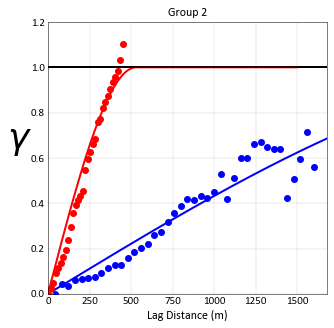

In [38]:
g = 2
varfl = gs.DataFile('Outputs/cp_out_fl_{}.out'.format(g))
modelfl=gs.DataFile('Outputs/cpmodel_file_out_{}.out'.format(g))
_ = gs.variogram_plot(varfl, index=1, title='Group {}'.format(g), grid=True, ms=7, figsize=(5,5), color='blue')
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', label="omni horizontal", )
gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red')
gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='images/cp_var_{}.png'.format(g), lw=2, color='red', label="vertical")
plt.legend(loc=4)

In [39]:
n_lags = 50
n_lagsv = 30

lag = 15
lagv = 30

lag_tol = lag/2
lag_tolv = lagv/2

In [40]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{flname}                 -file with data
2   3   4                         -   columns for X, Y, Z coordinates
1   {col_num}   {col_num}                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
0 91 1000 90 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlags}  {lag}  {lagtol}                 -        number of lags,lag distance,lag tolerance
{outfl}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1 10   1 {var}                      -tail variable, head variable, variogram type (and cutoff/category), sill
"""

g = 3
prop = np.sum(dfg['g3']['Cat'])/len(dfg['g3']['Cat'])
var = prop - prop ** 2
parstr_e = parstr.format(
        flname=dfg['g{}'.format(g)].flname,
        col_num=dfg['g{}'.format(g)].gscol('Cat'),
        nlags=n_lags,
        nlagsv=n_lagsv,
        lag=lag,
        lagv=lagv,
        lagtol=lag_tol,
        lagtolv=lag_tolv,
        var=var,
        outfl='Outputs/cp_out_fl_{}.out'.format(g))

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='Outputs/varcalc_g_{}_.par'.format(g))

Calling:  ['VARCALC/varcalc.exe', 'Outputs/varcalc_g_3_.par']

varcalc version:  1.400

  data file: data/cp_data_g3
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert   90.0000000000000        91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          50   15.0000000000000     
   7.50000000000000     
  output file: Outputs/cp_out_fl_3.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            1
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   1.00000000000000     
  standardizing with sill =  0.176223322402545   

In [41]:
varmodelpar = parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_out}                 -file for modeled variogram points output
1                           -number of directions to model points along
0.0   0.0  4000   0.5      -  azm, dip, npoints, point separation
1    0:0.5                   -nst, nugget effect
1 ?  0    0   0       -it,cc,azm,dip,tilt (ang1,ang2,ang3)
?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
2   1   2                    -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{model}              -  file to save fit variogram model
"""

g = 3
parstr = varmodelpar.format(model_out='Outputs/cpmodel_file_out_{}.out'.format(g), 
                                exp='Outputs/cp_out_fl_{}.out'.format(g), 
                                model='Outputs/cpvar_model_{}.out'.format(g))
    
var_model.run(parstr=parstr, liveoutput=True)

Calling:  ['VARMODEL/varmodel.exe', 'temp']

varmodel version: 1.1.1

  output points file: Outputs/cpmodel_file_out_3.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        4000  0.500000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.500000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Outputs/cp_out_fl_3.out
  using variograms            1           2
  # pairs wt, inv dist wt, min pairs:            1           0          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: Outputs/cpvar_model_3.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   4.906745786656887E-002
 Final objective value =   3.126608347182724E-002
  Modeling poin

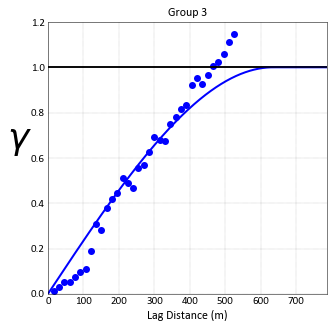

In [42]:
g = 3
varfl = gs.DataFile('Outputs/cp_out_fl_{}.out'.format(g))
modelfl=gs.DataFile('Outputs/cpmodel_file_out_{}.out'.format(g))
_ = gs.variogram_plot(varfl, index=1, title='Group {}'.format(g), grid=True, ms=7, figsize=(5,5), color='blue')
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', label="omni directional", output_file='images/cp_var_{}.png'.format(g))
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red')
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='images/cp_var_{}.png'.format(g), lw=2, color='red', label="vertical", )
#plt.legend(loc=4)

In [43]:
n_lags = 30
n_lagsv = 50

lag = 15
lagv = 30

lag_tol = lag/2
lag_tolv = lagv/2

In [44]:
parstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{flname}                 -file with data
2   3   4                         -   columns for X, Y, Z coordinates
1   {col_num}   {col_num}                         -   number of variables,column numbers (position used for tail,head variables below)
-998.0    1.0e21                  -   trimming limits
1                                 -number of directions
0 91 1000 90 91 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {nlags}  {lag}  {lagtol}                 -        number of lags,lag distance,lag tolerance
{outfl}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1 10   1 {var}                    -tail variable, head variable, variogram type (and cutoff/category), sill
"""

g = 4
prop = np.sum(dfg['g4']['Cat'])/len(dfg['g4']['Cat'])
var = prop - prop ** 2
parstr_e = parstr.format(
        flname=dfg['g{}'.format(g)].flname,
        col_num=dfg['g{}'.format(g)].gscol('Cat'),
        nlags=n_lags,
        nlagsv=n_lagsv,
        lag=lag,
        lagv=lagv,
        lagtol=lag_tol,
        lagtolv=lag_tolv,
        var=var,
        outfl='Outputs/cp_out_fl_{}.out'.format(g))

var_calc.run(parstr=parstr_e, liveoutput=True, parfile='Outputs/varcalc_g_{}_.par'.format(g))

Calling:  ['VARCALC/varcalc.exe', 'Outputs/varcalc_g_4_.par']

varcalc version:  1.400

  data file: data/cp_data_g4
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   91.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert   90.0000000000000        91.0000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          30   15.0000000000000     
   7.50000000000000     
  output file: Outputs/cp_out_fl_4.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            1
  number of variogram types:            1
 Variogram tail,head,type           1           1          10
  cutoff/category   1.00000000000000     
  standardizing with sill =  0.216704237680011   

In [45]:
varmodelpar = parstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{model_out}                 -file for modeled variogram points output
1                            -number of directions to model points along
0   0.0  4000   0.5      -  azm, dip, npoints, point separation
1    0:0.5                   -nst, nugget effect
1 ?  0    0   0       -it,cc,azm,dip,tilt (ang1,ang2,ang3)
?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{exp}                  -    experimental output file 1
2   1   2                    -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
1     1.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{model}              -  file to save fit variogram model
"""

g = 4
parstr = varmodelpar.format(model_out='Outputs/cpmodel_file_out_{}.out'.format(g), 
                                exp='Outputs/cp_out_fl_{}.out'.format(g), 
                                model='Outputs/cpvar_model_{}.out'.format(g))
    
var_model.run(parstr=parstr, liveoutput=True)

Calling:  ['VARMODEL/varmodel.exe', 'temp']

varmodel version: 1.1.1

  output points file: Outputs/cpmodel_file_out_4.out
  number of directions to model points along:            1
  azm, dip, npoints, pointsep:   0.000000000000000E+000  0.000000000000000E+000
        4000  0.500000000000000     
  nst =           1
 c0 constrained to  0.000000000000000E+000  0.500000000000000     
  fit model?            1      100000
  number of variogram files:            1
  variogram file: Outputs/cp_out_fl_4.out
  using variograms            1           2
  # pairs wt, inv dist wt, min pairs:            1           0          10
  fixhmaxvert,hmaxvert:            1   1.00000000000000     
  fixhminhmax,hminhmax:            1   1.00000000000000     
  variogram model output file: Outputs/cpvar_model_4.out
 Reading experimental variograms for variogram fitting
  Fitting variograms
 Starting objective value =   7.812355428798688E-002
 Final objective value =   5.838589629781200E-003
  Modeling poin

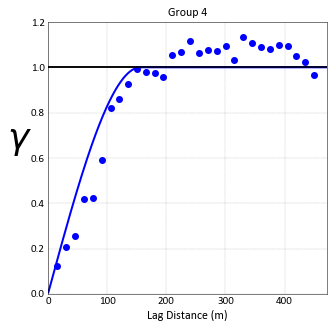

In [46]:
g = 4
varfl = gs.DataFile('Outputs/cp_out_fl_{}.out'.format(g))
modelfl=gs.DataFile('Outputs/cpmodel_file_out_{}.out'.format(g))
_ = gs.variogram_plot(varfl, index=1, title='Group {}'.format(g), grid=True, ms=7, figsize=(5,5), color='blue')
gs.variogram_plot(modelfl, index=1, experimental=False, ax= _, lw=2, color='blue', label="omni horizontal", output_file='images/cp_var_{}.png'.format(g))
#gs.variogram_plot(varfl, index=2, ax= _, grid=True, ms=7, color='red')
#gs.variogram_plot(modelfl, index=2, experimental=False, ax= _, output_file='images/cp_var_{}.png'.format(g), lw=2, color='red', label="vertical", ylim=[0,0.4])
#plt.legend(loc=4)

# Calibrating C

In [47]:
grid = cp.infergriddef(blksize=(25,25,15), databuffer=0)

In [48]:
grid

Pygeostat GridDef:
68 12.5 25.0 
52 12.5 25.0 
100 7.5 15.0

In [49]:
def aniso_support(var_file):
    f = open(var_file, "r")
    vario_str = f.readlines()
    a1, a2, a3 = vario_str[1].split()[2], vario_str[1].split()[3], vario_str[1].split()[4]
    r1 = float(vario_str[-1].split()[1])/float(vario_str[-1].split()[0])
    r2 = float(vario_str[-1].split()[2])/float(vario_str[-1].split()[0])
    r = float(vario_str[-1].split()[0])
    return r, '{} {} {} \n {} {}'.format(a1, a2, a3, r1, r2)

For group 1

In [50]:
support, aniso = aniso_support('Outputs/cpvar_model_{}.out'.format(1))

In [51]:
rbfuncertpar = '''
                        rbfuncert      
****************************************************************  
                                 
START OF PARAMETERS:            
{iputfl}                      -file with input indicator dataset   
1  2  3  4  {ind_col}                  - column for dhid(0 if 2D), x,y,z, indicator data  
-999                           - trimming value            
1 1                           -ncategories, categories      
{griddef}       
20   30   69069                -num random datasets, num C parameters, rseed 
1000                     -max c parameter, for each categorical variable  
0.10                           -proportion DHS/samples to remove  
1                              -RBFinterp type, (1:direct, 2:PU) - NOTE 1   
1   0.001                      -RBF kernel (NOTE 1.5), nugget effect  
1 {sup} {extr}                  - Support (0:manual,1:auto) - NOTE 2, support, extrapolation distance 
1                              -different anisotropic parameters for each cateogory (1=Yes,0=No) - NOTE 3  
{aniso}
{out}              -file for summary output - NOTE 4  
*** BPT parameter section: ***     
95  0.06  1                    -Partition paramters: dpc, d overlap, weight func (1 or 2) 
  0.35 0.35 0.35               - final partition overlap in x, y, z directions 
0                              -read BPT parameters from file(1=Yes,0=No)               
BPT_bounds.out                 -file with partition boundaries 
BPT_aniso_cat2_ref4.out        -file(s) with anisotropy for each category         
BPT_aniso_cat3_ref4.out        -file(s) with anisotropy for each category   
'''

rbfuncertpars = {
    'iputfl':dfg['g1'].flname,
    'ind_col':dfg['g1'].gscol("Cat"),
    'griddef':grid,
    'sup':support,
    'extr':str(1500),
    'aniso':aniso,
    'out':'Outputs/g1.out'
}

rbfuncert = gs.Program(program='RBFUNCERT/rbfuncert', parfile='Outputs/rbfuncertg1.par')

rbfuncert.run(parstr=rbfuncertpar.format(**rbfuncertpars))

Calling:  ['RBFUNCERT/rbfuncert', 'Outputs/rbfuncertg1.par']
 rbfuncert, Version :  1.00
Datafile: data/cp_data_g1                         
dhcol,xcol,ycol,zcol and datcol:   1  2  3  4  5
 trimming limit:         -999.00
 categories to model:   1
 nx, xmn, xsiz =   68        12.5000          25.0000
 ny, ymn, ysiz =   52        12.5000          25.0000
 nz, zmn, zsiz =  100         7.5000          15.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Using the defined support    278.770
Will only consider grid locations falling within this
  distance from data:    1500.00000
 Using unique aniostropic properties for each category 
 Using the following for all categories: 
Using these angles:             0.00000      0.00000      0.00000
 minor/major, vert/major:       1.00000      1.00000
File for summary output: Outputs/g1.out
 
Generating   20 of jackknife datasets to train the C parameter
Jackknifing   20 datasets to train the c parameter
Working on d

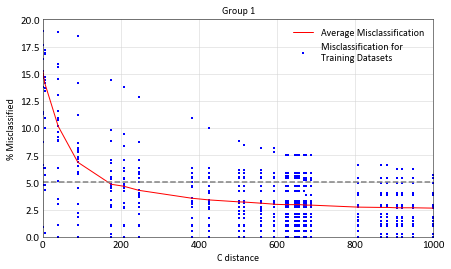

In [52]:
cparsum = gs.DataFile('Outputs/g1_1.out').data.values
cpars = cparsum[:, 0]
errs = cparsum[:, 1:]
f, axs = plt.subplots(1,1,figsize=(7,4))
for j in range(np.size(errs,1)):
    if j == 0:
        label = 'Misclassification for \nTraining Datasets'
    else:
        label = None
    axs.scatter(cpars, errs[:,j], marker='+', c='b', s=8, label=label)
axs.plot(cpars, np.mean(errs, 1), lw=1, c='r', label='Average Misclassification')
axs.legend(fontsize=10)
axs.grid()
axs.set_xlim([0, 1000])
axs.set_ylim([0,20])
axs.set_ylabel('% Misclassified', fontsize=10)
axs.set_xlabel('C distance', fontsize=10)
axs.set_title('Group 1', fontsize=10)

axs.axhline(5, color="gray", ls="--")
#axs.vlines(230, 0, 5, linestyles='dashed')

plt.savefig('images/uncert_g1.png')

For group 2

In [53]:
support, aniso = aniso_support('Outputs/cpvar_model_{}.out'.format(2))

In [54]:
rbfuncertpar = '''
                        rbfuncert      
****************************************************************  
                                 
START OF PARAMETERS:            
{iputfl}                      -file with input indicator dataset   
1  2  3  4  {ind_col}                  - column for dhid(0 if 2D), x,y,z, indicator data  
-999                           - trimming value            
1 1                           -ncategories, categories      
{griddef}       
20   30   69069                -num random datasets, num C parameters, rseed 
200                     -max c parameter, for each categorical variable  
0.10                           -proportion DHS/samples to remove  
1                              -RBFinterp type, (1:direct, 2:PU) - NOTE 1   
1   0.001                      -RBF kernel (NOTE 1.5), nugget effect  
1 {sup} {extr}                  - Support (0:manual,1:auto) - NOTE 2, support, extrapolation distance 
1                              -different anisotropic parameters for each cateogory (1=Yes,0=No) - NOTE 3  
{aniso}
{out}              -file for summary output - NOTE 4  
*** BPT parameter section: ***     
95  0.06  1                    -Partition paramters: dpc, d overlap, weight func (1 or 2) 
  0.35 0.35 0.35               - final partition overlap in x, y, z directions 
0                              -read BPT parameters from file(1=Yes,0=No)               
BPT_bounds.out                 -file with partition boundaries 
BPT_aniso_cat2_ref4.out        -file(s) with anisotropy for each category         
BPT_aniso_cat3_ref4.out        -file(s) with anisotropy for each category   
'''

rbfuncertpars = {
    'iputfl':dfg['g2'].flname,
    'ind_col':dfg['g2'].gscol("Cat"),
    'griddef':grid,
    'sup':support,
    'extr':str(1500),
    'aniso':aniso,
    'out':'Outputs/g2.out'
}

rbfuncert = gs.Program(program='RBFUNCERT/rbfuncert', parfile='Outputs/rbfuncertg2.par')

rbfuncert.run(parstr=rbfuncertpar.format(**rbfuncertpars))

Calling:  ['RBFUNCERT/rbfuncert', 'Outputs/rbfuncertg2.par']
 rbfuncert, Version :  1.00
Datafile: data/cp_data_g2                         
dhcol,xcol,ycol,zcol and datcol:   1  2  3  4  5
 trimming limit:         -999.00
 categories to model:   1
 nx, xmn, xsiz =   68        12.5000          25.0000
 ny, ymn, ysiz =   52        12.5000          25.0000
 nz, zmn, zsiz =  100         7.5000          15.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Using the defined support   3370.220
Will only consider grid locations falling within this
  distance from data:    1500.00000
 Using unique aniostropic properties for each category 
 Using the following for all categories: 
Using these angles:             0.00000      0.00000      0.00000
 minor/major, vert/major:       1.00000      0.15758
File for summary output: Outputs/g2.out
 
Generating   20 of jackknife datasets to train the C parameter
Jackknifing   20 datasets to train the c parameter
Working on d

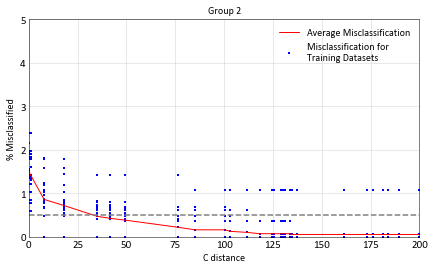

In [55]:
cparsum = gs.DataFile('Outputs/g2_1.out').data.values
cpars = cparsum[:, 0]
errs = cparsum[:, 1:]
f, axs = plt.subplots(1,1,figsize=(7,4))
for j in range(np.size(errs,1)):
    if j == 0:
        label = 'Misclassification for \nTraining Datasets'
    else:
        label = None
    axs.scatter(cpars, errs[:,j], marker='+', c='b', s=8, label=label)
axs.plot(cpars, np.mean(errs, 1), lw=1, c='r', label='Average Misclassification')
axs.legend(fontsize=10)
axs.grid()
axs.set_xlim([0, 200])
axs.set_ylim([0,5])
axs.set_ylabel('% Misclassified', fontsize=10)
axs.set_xlabel('C distance', fontsize=10)
axs.set_title('Group 2', fontsize=10)

#axs.hlines(15, 0, 150, linestyles='dashed')
#axs.vlines(150, 0, 15, linestyles='dashed')
axs.axhline(0.5, color="gray", ls="--")


plt.savefig('images/uncert_g2.png')

For group 3

In [56]:
support, aniso = aniso_support('Outputs/cpvar_model_{}.out'.format(3))

In [57]:
rbfuncertpar = '''
                        rbfuncert      
****************************************************************  
                                 
START OF PARAMETERS:            
{iputfl}                      -file with input indicator dataset   
1  2  3  4  {ind_col}                  - column for dhid(0 if 2D), x,y,z, indicator data  
-999                           - trimming value            
1 1                           -ncategories, categories      
{griddef}       
20   30   69069                -num random datasets, num C parameters, rseed 
400                     -max c parameter, for each categorical variable  
0.10                           -proportion DHS/samples to remove  
1                              -RBFinterp type, (1:direct, 2:PU) - NOTE 1   
1   0.001                      -RBF kernel (NOTE 1.5), nugget effect  
1 {sup} {extr}                  - Support (0:manual,1:auto) - NOTE 2, support, extrapolation distance 
1                              -different anisotropic parameters for each cateogory (1=Yes,0=No) - NOTE 3  
{aniso}
{out}              -file for summary output - NOTE 4  
*** BPT parameter section: ***     
95  0.06  1                    -Partition paramters: dpc, d overlap, weight func (1 or 2) 
  0.35 0.35 0.35               - final partition overlap in x, y, z directions 
0                              -read BPT parameters from file(1=Yes,0=No)               
BPT_bounds.out                 -file with partition boundaries 
BPT_aniso_cat2_ref4.out        -file(s) with anisotropy for each category         
BPT_aniso_cat3_ref4.out        -file(s) with anisotropy for each category   
'''

rbfuncertpars = {
  'iputfl':dfg['g3'].flname,
    'ind_col':dfg['g3'].gscol("Cat"),
    'griddef':grid,
    'sup':support,
    'extr':str(1500),
    'aniso':aniso,
    'out':'Outputs/g3.out'
}

rbfuncert = gs.Program(program='RBFUNCERT/rbfuncert', parfile='Outputs/rbfuncertg3.par')

rbfuncert.run(parstr=rbfuncertpar.format(**rbfuncertpars))

Calling:  ['RBFUNCERT/rbfuncert', 'Outputs/rbfuncertg3.par']
 rbfuncert, Version :  1.00
Datafile: data/cp_data_g3                         
dhcol,xcol,ycol,zcol and datcol:   1  2  3  4  5
 trimming limit:         -999.00
 categories to model:   1
 nx, xmn, xsiz =   68        12.5000          25.0000
 ny, ymn, ysiz =   52        12.5000          25.0000
 nz, zmn, zsiz =  100         7.5000          15.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Using the defined support    634.570
Will only consider grid locations falling within this
  distance from data:    1500.00000
 Using unique aniostropic properties for each category 
 Using the following for all categories: 
Using these angles:             0.00000      0.00000      0.00000
 minor/major, vert/major:       1.00000      1.00000
File for summary output: Outputs/g3.out
 
Generating   20 of jackknife datasets to train the C parameter
Jackknifing   20 datasets to train the c parameter
Working on d

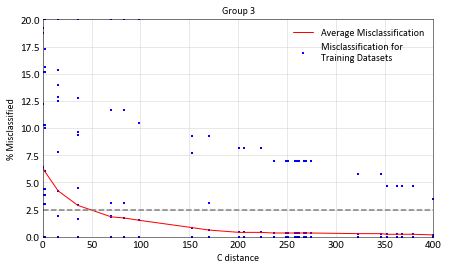

In [58]:
cparsum = gs.DataFile('Outputs/g3_1.out').data.values
cpars = cparsum[:, 0]
errs = cparsum[:, 1:]
f, axs = plt.subplots(1,1,figsize=(7,4))
for j in range(np.size(errs,1)):
    if j == 0:
        label = 'Misclassification for \nTraining Datasets'
    else:
        label = None
    axs.scatter(cpars, errs[:,j], marker='+', c='b', s=8, label=label)
axs.plot(cpars, np.mean(errs, 1), lw=1, c='r', label='Average Misclassification')
axs.legend(fontsize=10)
axs.grid()
axs.set_xlim([0, 400])
axs.set_ylim([0,20])
axs.set_ylabel('% Misclassified', fontsize=10)
axs.set_xlabel('C distance', fontsize=10)
axs.set_title('Group 3', fontsize=10)

#axs.hlines(5, 0, 75, linestyles='dashed')
#axs.vlines(75, 0, 5, linestyles='dashed')
axs.axhline(2.5, color="gray", ls="--")

plt.savefig('images/uncert_g3.png', delim=None)

For group 4

In [59]:
support, aniso = aniso_support('Outputs/cpvar_model_{}.out'.format(4))

In [60]:
rbfuncertpar = '''
                        rbfuncert      
****************************************************************  
                                 
START OF PARAMETERS:            
{iputfl}                      -file with input indicator dataset   
1  2  3  4  {ind_col}                  - column for dhid(0 if 2D), x,y,z, indicator data  
-999                           - trimming value            
1 1                           -ncategories, categories      
{griddef}       
20   30   69069                -num random datasets, num C parameters, rseed 
600                     -max c parameter, for each categorical variable  
0.10                           -proportion DHS/samples to remove  
1                              -RBFinterp type, (1:direct, 2:PU) - NOTE 1   
1   0.001                      -RBF kernel (NOTE 1.5), nugget effect  
1 {sup} {extr}                  - Support (0:manual,1:auto) - NOTE 2, support, extrapolation distance 
0                              -different anisotropic parameters for each cateogory (1=Yes,0=No) - NOTE 3  
{aniso}
{out}              -file for summary output - NOTE 4  
*** BPT parameter section: ***     
95  0.06  1                    -Partition paramters: dpc, d overlap, weight func (1 or 2) 
  0.35 0.35 0.35               - final partition overlap in x, y, z directions 
0                              -read BPT parameters from file(1=Yes,0=No)               
BPT_bounds.out                 -file with partition boundaries 
BPT_aniso_cat2_ref4.out        -file(s) with anisotropy for each category         
BPT_aniso_cat3_ref4.out        -file(s) with anisotropy for each category   
'''

rbfuncertpars = {
  'iputfl':dfg['g4'].flname,
    'ind_col':dfg['g4'].gscol("Cat"),
    'griddef':grid,
    'sup':support,
    'extr':str(1500),
    'aniso':aniso,
    'out':'Outputs/g4.out'
}

rbfuncert = gs.Program(program='RBFUNCERT/rbfuncert', parfile='Outputs/rbfuncertg4.par')

rbfuncert.run(parstr=rbfuncertpar.format(**rbfuncertpars))

Calling:  ['RBFUNCERT/rbfuncert', 'Outputs/rbfuncertg4.par']
 rbfuncert, Version :  1.00
Datafile: data/cp_data_g4                         
dhcol,xcol,ycol,zcol and datcol:   1  2  3  4  5
 trimming limit:         -999.00
 categories to model:   1
 nx, xmn, xsiz =   68        12.5000          25.0000
 ny, ymn, ysiz =   52        12.5000          25.0000
 nz, zmn, zsiz =  100         7.5000          15.0000
 Interpolation Type:  Direct              
 Kernel Type: Gaussian            
Using the defined support    156.340
Will only consider grid locations falling within this
  distance from data:    1500.00000
 Using one set of aniostropic properties for all categories 
 Using the following for all categories: 
Using these angles:             0.00000      0.00000      0.00000
 minor/major, vert/major:       1.00000      1.00000
File for summary output: Outputs/g4.out
 
Generating   20 of jackknife datasets to train the C parameter
Jackknifing   20 datasets to train the c parameter
Working

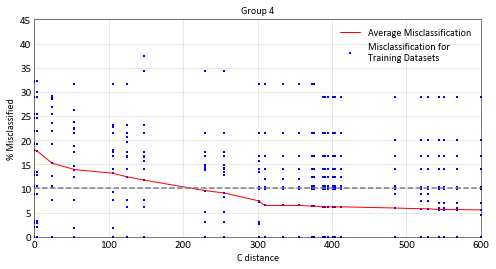

In [61]:
cparsum = gs.DataFile('Outputs/g4_1.out').data.values
cpars = cparsum[:, 0]
errs = cparsum[:, 1:]
f, axs = plt.subplots(1,1,figsize=(8,4))
for j in range(np.size(errs,1)):
    if j == 0:
        label = 'Misclassification for \nTraining Datasets'
    else:
        label = None
    axs.scatter(cpars, errs[:,j], marker='+', c='b', s=8, label=label)
axs.plot(cpars, np.mean(errs, 1), lw=1, c='r', label='Average Misclassification')
axs.legend(fontsize=10)
axs.grid()
axs.set_xlim([0, 600])
axs.set_ylim([0,45])
axs.set_ylabel('% Misclassified', fontsize=10)
axs.set_xlabel('C distance', fontsize=10)
axs.set_title('Group 4', fontsize=10)

#axs.hlines(0.5, 0, 74, linestyles='dashed')
#axs.vlines(74, 0, 0.5, linestyles='dashed')
axs.axhline(10, color="gray", ls="--")

plt.savefig('images/uncert_g4.png', delim=None)

# Chosing C values

In [62]:
#calibration #divided by 10 it validates with the reference model
c_values = {
    1:170,
    2:30,
    3:50,
    4:200
}

In [63]:
print(c_values)

{1: 170, 2: 30, 3: 50, 4: 200}


# Simulating

Getting gaussian varioogram equivalents

In [64]:
def gauss_tr_varg(varg_file):
    f = open(varg_file, "r")
    varstr = f.readlines()
    
    for idx, i in enumerate(varstr):
        if idx == 0:
            l = i.split()
            l[1] = " 0.0000009 "
            l[-1] = " \n "
            varstr[idx] = ' '.join(l)
        else:
            l = i.split()
            if l[0] == '1':
                l[0] = " 3 "
                l[-1] = " \n "
                varstr[idx] = ' '.join(l)
                
    return ''.join(varstr)

In [65]:
for i in [1,2,3,4]:
    print(gauss_tr_varg('Outputs/cpvar_model_{}.out'.format(i)))

1  0.0000009  -nst, nugget  
  3  1.00000 0.00000 0.00000 0.00000 -it,cc,azm,dip,tilt  
         278.77000        278.77000        278.77000    -a_hmax, a_hmin, a_vert (ranges)

1  0.0000009  -nst, nugget  
  3  1.00000 0.00000 0.00000 0.00000 -it,cc,azm,dip,tilt  
        3370.22000       3370.22000        531.09000    -a_hmax, a_hmin, a_vert (ranges)

1  0.0000009  -nst, nugget  
  3  1.00000 0.00000 0.00000 0.00000 -it,cc,azm,dip,tilt  
         634.57000        634.57000        634.57000    -a_hmax, a_hmin, a_vert (ranges)

1  0.0000009  -nst, nugget  
  3  1.00000 0.00000 0.00000 0.00000 -it,cc,azm,dip,tilt  
         156.34000        156.34000        156.34000    -a_hmax, a_hmin, a_vert (ranges)



In [66]:
t = '''1       0.00000    -nst, nugget effect
  1       0.05       0.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
       1688.41000       1688.41000        634.34000    -a_hmax, a_hmin, a_vert (ranges)'''

In [67]:
nreals = 10

In [68]:
usgsimpar = '''
               Parameters for UltimateSGSIM
               ****************************

START OF MAIN:
{nreals}                      -number of realizations to generate, 0=kriging
1                             -number of variables being simulated
0                             -number of rock types to consider
{seed}                         -random number seed
{griddef}
{outfl}                     -file for simulation output
0                             -  output format: (0=reg, 1=coord, 2=bin)
impute.out                    -file for imputed values in case of heterotopic samples
0                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output

START OF SRCH:
12                           -number of data to use per variable
3000 3000 3000            -maximum search radii (hmax,hmin,vert)
0.0    0.0    0.0             -angles for search ellipsoid
0                             -sort by distance (0) or covariance (1)
1 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use

START OF VARG:
1                             -number of variograms
0  1  1                       -rock type, variable 1, variable 2
{varg}
'''

callpars = []

groups = [1,2,3,4]

for g in groups:
        
    usgsimpars = {
        'seed':gs.rseed(),
        'nreals':str(nreals),
        'griddef':grid,
        'outfl':'Outputs/uncondsim_{}.out'.format(g),
        'varg':gauss_tr_varg('Outputs/cpvar_model_{}.out'.format(g))
         #'varg':t,
         }
    
    callpars.append({'parstr':usgsimpar.format(**usgsimpars), 'parfile':'Outputs/usgsimpar_{}.par'.format(g)})

    
usgsim = gs.Program(program='USGSIM/usgsim', parstr='Outputs/usgsim.par')
gs.runparallel(usgsim, callpars)

Creating parallel processes
Pool assembled, asynchronously processing
Asynchronous execution finished.


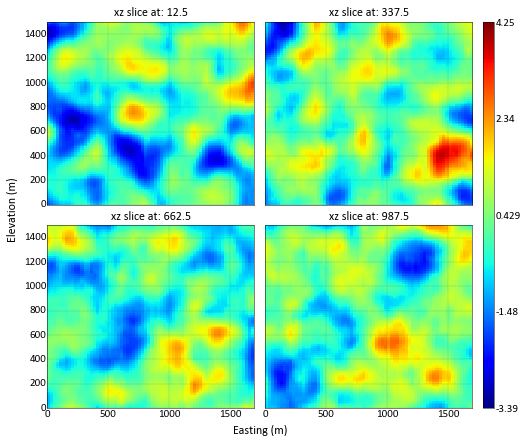

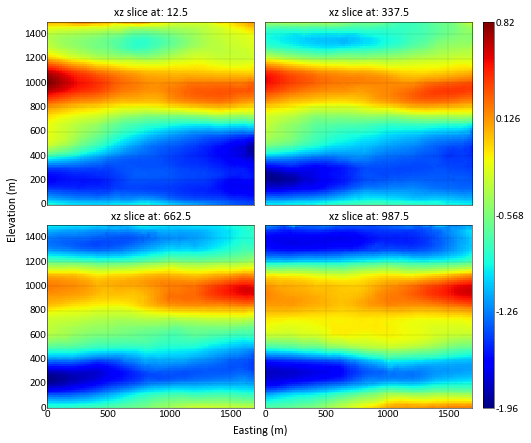

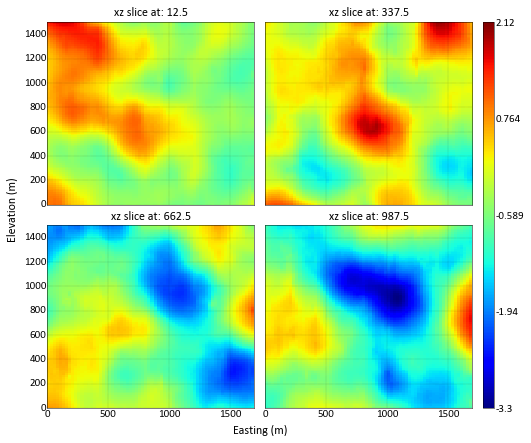

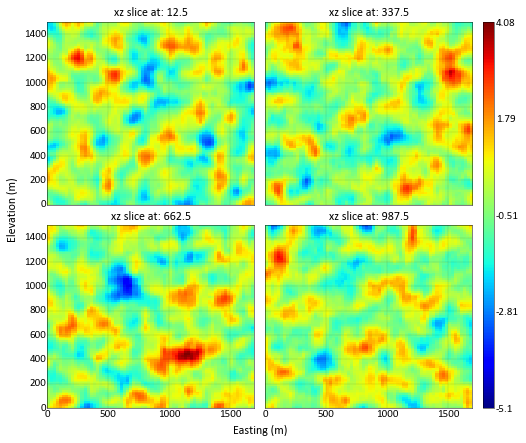

In [69]:
for g in [1,2,3,4]:
    sgsim = gs.DataFile(flname='Outputs/uncondsim_{}.out'.format(g))
    sgsim_vals = np.reshape(sgsim.data.values, (grid.count(), nreals), order='F')
    sgsim_pd = pd.DataFrame(columns=['real {}'.format(c) for c in range(nreals)], data=sgsim_vals)        
    _ = gs.grid_slice_plot(sgsim_pd['real 0'], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/undond_real_{}.png'.format(g))

# Interpolating

In [70]:
parstr = """                        rbfdfmod
                        ********

START OF PARAMETERS:
{flname}                -file with input dataset
2  3  4  5               - column for x, y, z, indicator data
-999                     - trimming value
1 1                  -ncats, category indicator
keyout.dat               -file with the keyout model
1  1                     - column for keyout variable, value to keep
{griddef}
1  {c}               -RBFinterp type (1:direct, 2:POU)-NOTE 1, trained C parameter(s)-NOTE 3
1  0.001                 - RBF kernel (NOTE 2), Nugget Effect
0  {support}  10000              - Support (0:manual,1:auto) - NOTE 2, support distance, extrapolation distance
1                        -Use different anisotropy for each category? (1=Yes,0=No) - NOTE 4
{anis}
2    6                   -Ouput: (1) indicators or (2) signed distacnce function, numthreads for parallel SDF
{outfl}                -file for interpolated output
*** BPT parameter section: ***  
95  0.06  1              -Partition paramters: dpc, d overlap, weight func (1 or 2, see paper)
 0.5 0.5 0.5             - final partition overlap in x, y, z directions
0                        -read BPT parameters from file(1=Yes,0=No) - NOTE 6
BPT_bounds.out           -file with partition boundaries
BPT_aniso_cat2_ref4.out  -file(s) with anisotropy for each category
"""

callpars = []

groups = [1,2,3,4]

for g in groups:
    
    support, anis = aniso_support('Outputs/cpvar_model_{}.out'.format(g))
    
    rbfmodpars = {
        'flname':'data/cp_data_g{}'.format(g),
        'griddef':grid,
        'c':c_values[g],
        'support':support,
        'anis':anis,
        'outfl':'Outputs/mod_dist_rbf_{}.out'.format(g),
    }
    
    callpars.append({'parstr':parstr.format(**rbfmodpars), 'parfile':'Outputs/rbfdfmodpar_{}.par'.format(g)})

    
rbfdfmod = gs.Program(program='RBFDFMOD/rbfdfmod', parstr='Outputs/rbfdfmodpar.par')
gs.runparallel(rbfdfmod, callpars)

Creating parallel processes
Pool assembled, asynchronously processing
Asynchronous execution finished.


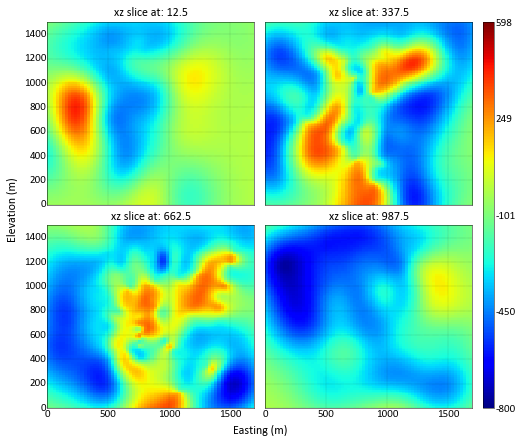

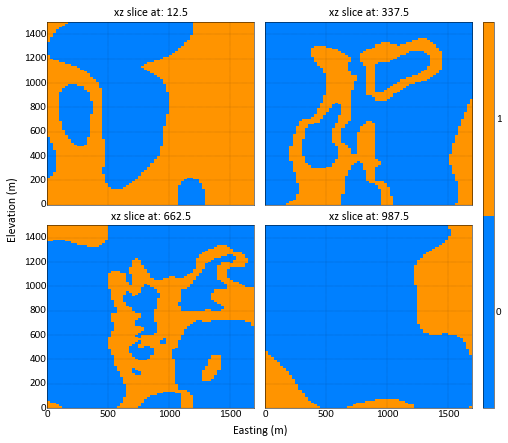

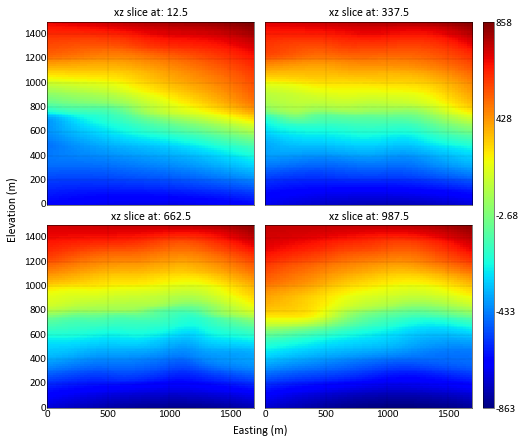

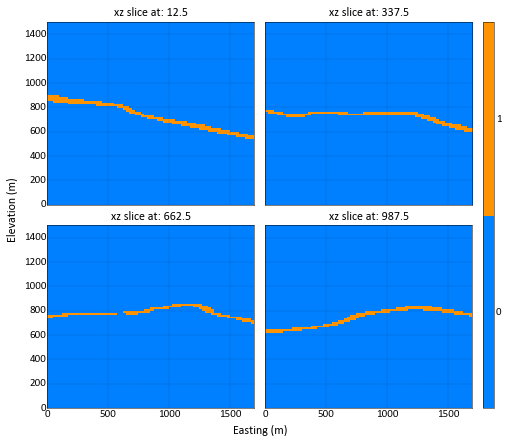

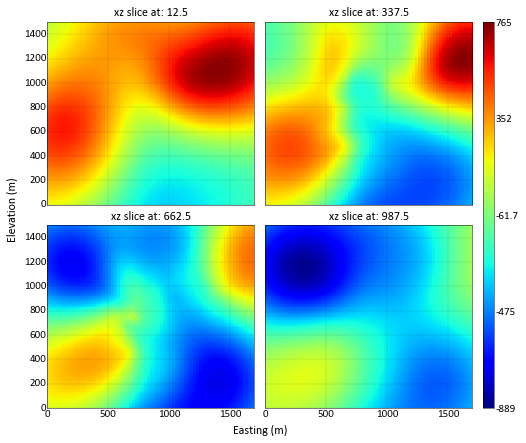

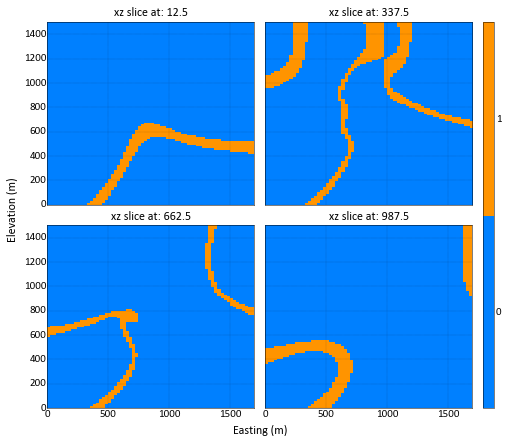

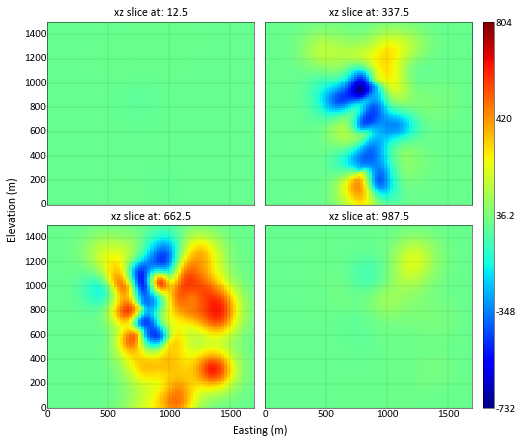

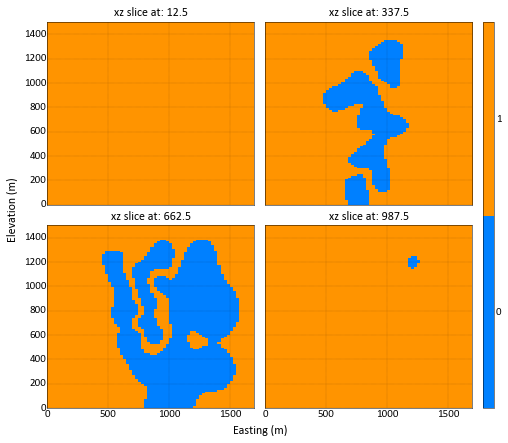

In [71]:
groups = [1,2,3,4]
for g in groups:
    fl_est = gs.DataFile('Outputs/mod_dist_rbf_{}.out'.format(g), griddef=grid, tmin=-10e100)
    #print(len(fl_est), griddef.count())
    gs.write_vtk(fl_est, 'Outputs/dfmod_{}'.format(g))
    c_zone = np.where((fl_est['Cat_1'] > -c_values[g]) & (fl_est['Cat_1'] < c_values[g]), 1, 0)
    _ = gs.grid_slice_plot(fl_est, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/g_real_{}.png'.format(g))
    _ = gs.grid_slice_plot(c_zone, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/zone_g_real_{}.png'.format(g))

# Clipping

In [72]:
sdfclippar = '''
                         Parameters for SDFCLIP
                         **********************
START OF PARAMETERS:
{est}                           -file with kriged signed distance function
1                                  - column with estimates
{sim}                          -file with simulated threshold model
1                                  - column with value
1 -{c} {c}                         - convert to uniform (1=yes) with range min max
-10e30 10e30                         -trimming limits
{nx} {ny} {nz} {nreals}                     -nx, ny, nz, nrealization
1                                -cell volume
{outind}                         -file for output indicator model
{volout}                         -file for volume summary
'''

callpars = []

groups = [1,2,3,4]

for g in groups:
    
    support, anis = aniso_support('Outputs/cpvar_model_{}.out'.format(g))
    
    sdfclippars = {
        'nreals':str(nreals),
        'est':'Outputs/mod_dist_rbf_{}.out'.format(g),
        'sim':'Outputs/uncondsim_{}.out'.format(g),
        'c':c_values[g],
        'outind':'Outputs/clip_ind_{}.out'.format(g),
        'volout':'Outputs/clip_vol_{}.out'.format(g),
        'nx':grid.nx,
        'ny':grid.ny,
        'nz':grid.nz,
    }
    
    callpars.append({'parstr':sdfclippar.format(**sdfclippars), 'parfile':'Outputs/sdfclippar_{}.par'.format(g)})

    
sdfclip = gs.Program(program='SDFCLIP/sdfclip', parstr='Outputs/sdfclippar.par')
gs.runparallel(sdfclip, callpars)

Creating parallel processes
Pool assembled, asynchronously processing
Asynchronous execution finished.


# Reading simulations

In [73]:
group1 = gs.DataFile('Outputs/clip_ind_1.out', griddef=grid).data.values
group1 = np.reshape(group1, (grid.count(), nreals), order='F')
g1_df = pd.DataFrame(group1, columns=['real_{}'.format(i) for i in range(nreals)])

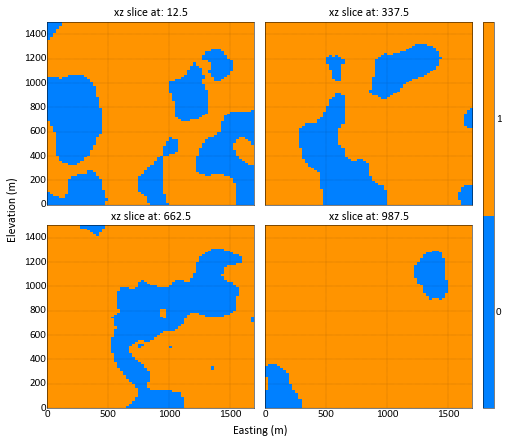

In [74]:
_ = gs.grid_slice_plot(g1_df['real_0'], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/g1_real_{}.png'.format(g))

In [75]:
group2 = gs.DataFile('Outputs/clip_ind_2.out', griddef=grid).data.values
group2 = np.reshape(group2, (grid.count(), nreals), order='F')
g2_df = pd.DataFrame(group2, columns=['real_{}'.format(i) for i in range(nreals)])

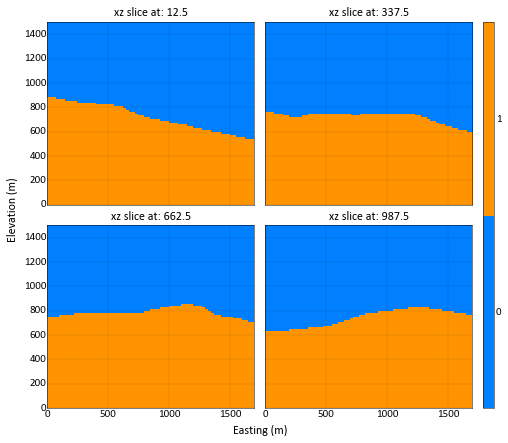

In [76]:
_ = gs.grid_slice_plot(g2_df['real_0'], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/g2_real_{}.png'.format(g))

In [77]:
group3 = gs.DataFile('Outputs/clip_ind_3.out', griddef=grid).data.values
group3 = np.reshape(group3, (grid.count(), nreals), order='F')
g3_df = pd.DataFrame(group3, columns=['real_{}'.format(i) for i in range(nreals)])

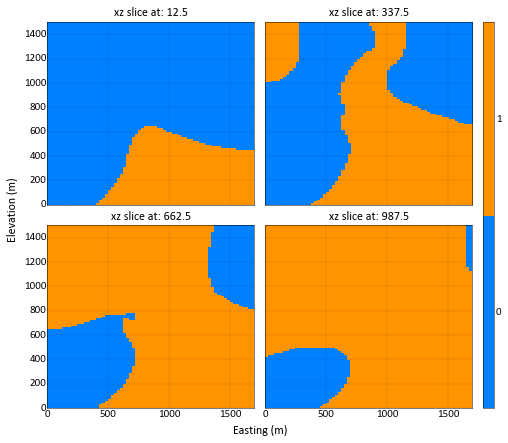

In [78]:
_ = gs.grid_slice_plot(g3_df['real_0'], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/g3_real_{}.png'.format(g))

In [79]:
group4 = gs.DataFile('Outputs/clip_ind_4.out', griddef=grid).data.values
group4 = np.reshape(group4, (grid.count(), nreals), order='F')
g4_df = pd.DataFrame(group4, columns=['real_{}'.format(i) for i in range(nreals)])

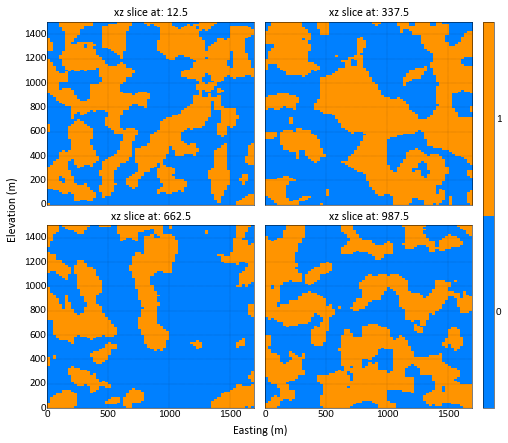

In [80]:
_ = gs.grid_slice_plot(g4_df['real_0'], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/g4_real_{}.png'.format(g))

In [81]:
gs.write_gslib(g1_df, 'Outputs/g1_reals.dat')

In [82]:
gs.write_gslib(g2_df, 'Outputs/g2_reals.dat')

In [83]:
gs.write_gslib(g3_df, 'Outputs/g3_reals.dat')

In [84]:
gs.write_gslib(g4_df, 'Outputs/g4_reals.dat')

# getting everything together

In [85]:
groups_dic = {
    'g1':g1_df,
    'g2':g2_df,
    'g3':g3_df,
    'g4':g4_df,
}

In [86]:
reals_pd = []
for real in range(nreals):
    reals_pd.append(np.ones(len(groups_dic['g1']))*float('nan'))
reals_pd = np.reshape(reals_pd, (grid.count(), nreals), order='F')

In [87]:
maps

{'g1': {1.0: 1, 2.0: 1, 4.0: 0, 3.0: 0, 5.0: 0},
 'g2': {1.0: 1, 2.0: 0},
 'g3': {3.0: 1, 4.0: 1, 5.0: 0},
 'g4': {3.0: 1, 4.0: 0}}

In [88]:
for real in range(nreals):
    for value in range(len(groups_dic['g1'])):
        if groups_dic['g1'].iloc[value][real] == 1 and groups_dic['g2'].iloc[value][real] == 1:
            reals_pd[value][real] = 1
        if groups_dic['g1'].iloc[value][real] == 1 and groups_dic['g2'].iloc[value][real] == 0:
            reals_pd[value][real] = 2
        if groups_dic['g1'].iloc[value][real] == 0 and groups_dic['g3'].iloc[value][real] == 0:
             reals_pd[value][real] = 5
        if groups_dic['g1'].iloc[value][real] == 0 and groups_dic['g3'].iloc[value][real] == 1 and groups_dic['g4'].iloc[value][real] == 1:
             reals_pd[value][real] = 3
        if groups_dic['g1'].iloc[value][real] == 0 and groups_dic['g3'].iloc[value][real] == 1 and groups_dic['g4'].iloc[value][real] == 0:
             reals_pd[value][real] = 4

In [89]:
reals = pd.DataFrame(reals_pd, columns=['real_{}'.format(i) for i in range(nreals)])

In [90]:
reals.head()

,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,real_8,real_9
0,5.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0
1,5.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0
2,5.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0
3,5.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0
4,5.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0


Saving reals

In [91]:
gs.write_gslib(reals, 'Outputs/reals_exaust.out')

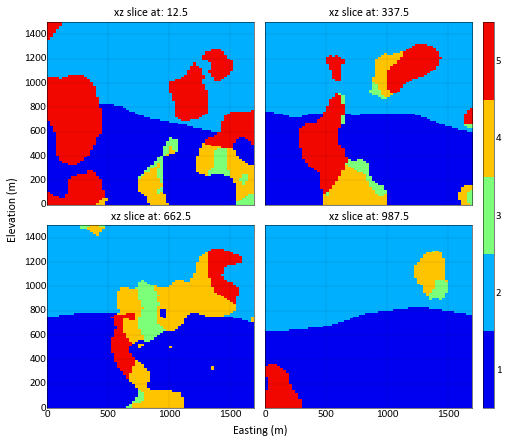

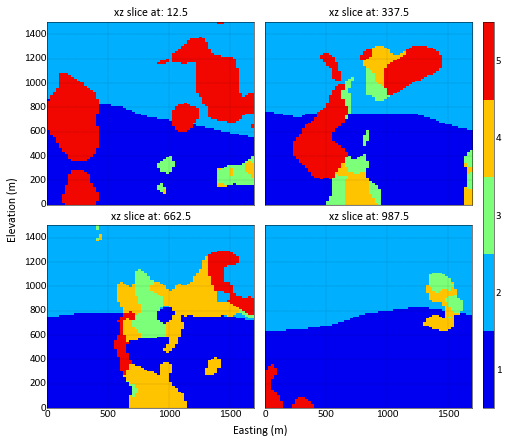

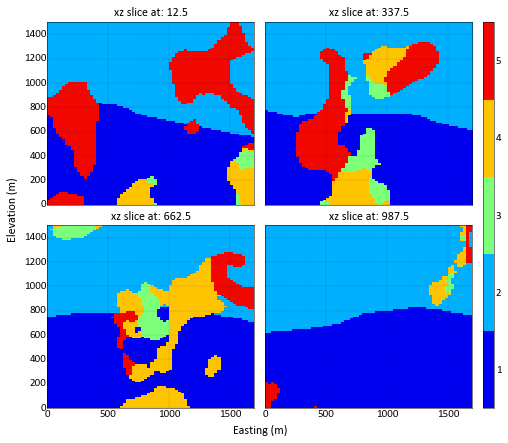

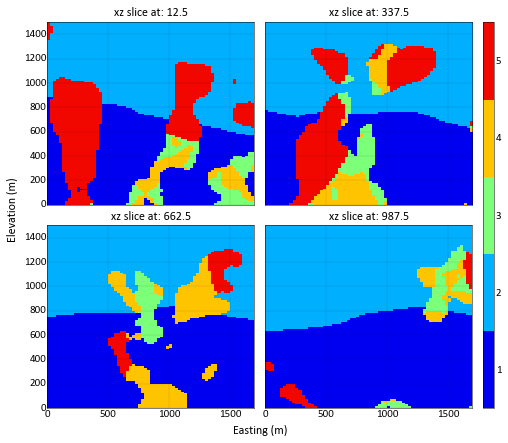

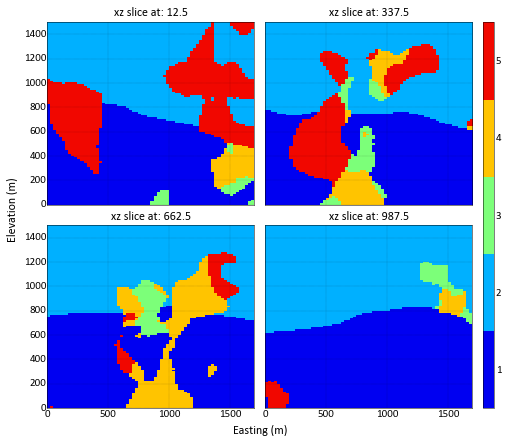

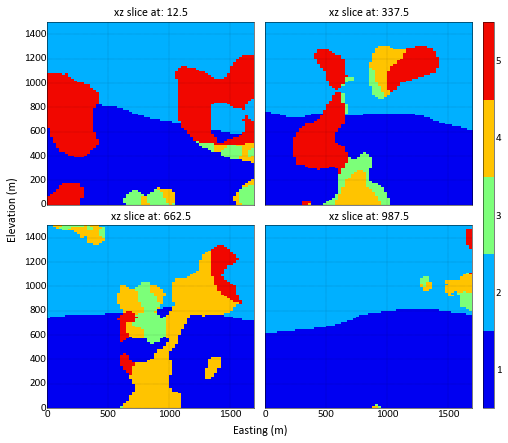

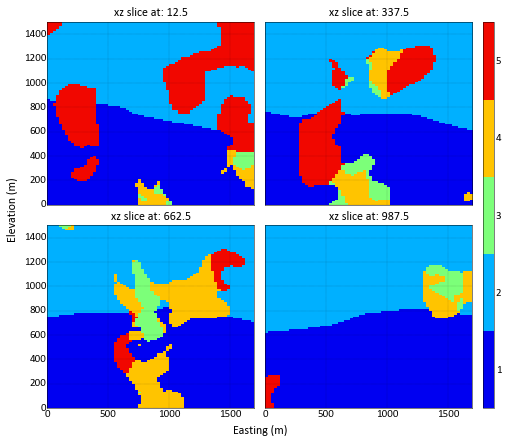

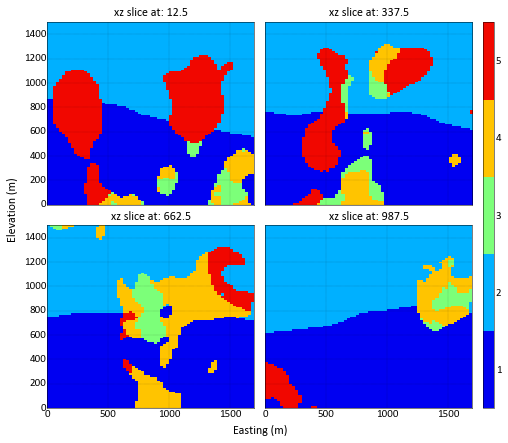

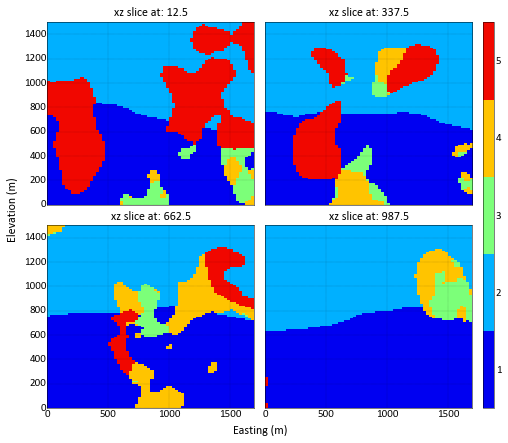

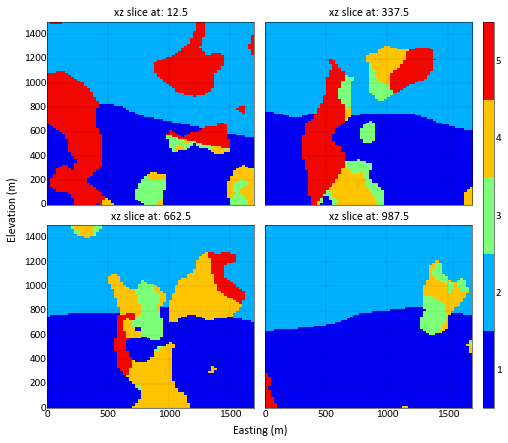

In [92]:
for i in range(nreals):
    _ = gs.grid_slice_plot(reals['real_{}'.format(i)], griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/real_{}.png'.format(i))

In [93]:
reals_df = gs.DataFile('Outputs/reals_exaust.out', griddef=grid)
reals_df.write_file('Outputs/reals', fltype='vtk',)

# validating

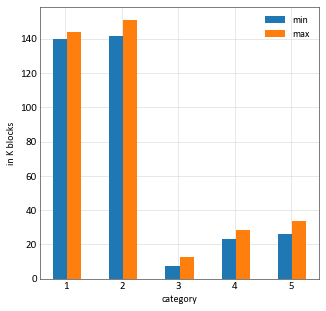

In [94]:
volume_diff(reals_df, output='images/bars.png')

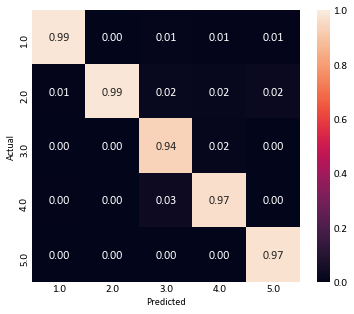

In [95]:
backflag(x=cp['X'], y=cp['Y'], z=cp['Z'], prop=cp['Cat'], grid=grid, reals=reals_df)

In [97]:
shanon_entropy = entropy(reals_df.data)

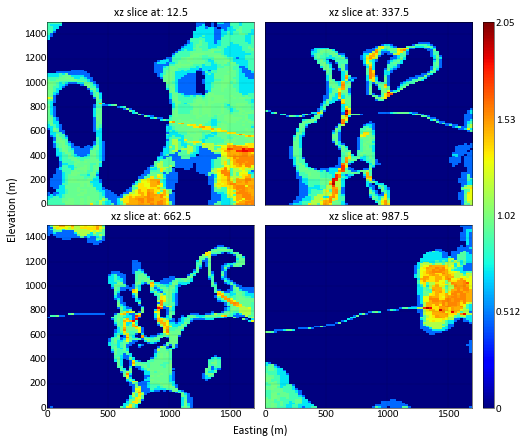

In [98]:
_ = gs.grid_slice_plot(shanon_entropy, griddef=grid, cmap='jet', grid=True, orient='xz', output_file='images/hierbound_entropy.png')